Enabled vectore-store memory. Cover two use cases in demo:
- LLM extract key info about user preferences, and give personalized recommendations -> If user killed a session and started a new session, LLM remember user preference without needing to re-prompt
- Built a filter so LLM does not rememeber PII (names, address, etc)

In [1]:
# Set up environment - Need OpenAI and Langchain API keys

import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")


In [2]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [7]:
import chromadb
import chromadb.utils.embedding_functions as embedding_functions

persist_directory = '/Users/kaiding/Documents/MIDS/Capstone'
emb_fn = embedding_functions.OpenAIEmbeddingFunction(api_key=os.environ["OPENAI_API_KEY"])
vectordb = chromadb.PersistentClient(path=persist_directory)

#vectordb.delete_collection("recall_vectore_store")
#vectordb.delete_collection("vectore_store")

In [8]:
# create vector collection
recall_vector_store = vectordb.create_collection(
    name="recall_vectore_store", 
    embedding_function=emb_fn)

In [9]:
recall_vector_store

Collection(id=c7f27668-964a-497d-9c85-480d2c939fc1, name=recall_vectore_store)

In [10]:
# Helper function to create agent team
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    llm_with_tools = llm.bind_tools(tools)
    agent_chain = (
        prompt |
        llm_with_tools
    )
    return agent_chain

In [11]:
# Create agent graph state, which is set of attributes shared by all agents

import functools
import operator
from typing import Sequence, TypedDict, List
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from typing import Annotated

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    recall_memories: Annotated[Sequence[str], operator.add]
    # The 'next' field indicates where to route to next
    next: str

In [12]:
# Define agent nodes and human feedback nodes

def agent_node(state, agent, name):
    #print(f"Config input: {config}")
    # create tagging for memory
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    result = agent.invoke({
        "messages": state["messages"],
        "recall_memories": recall_str,
    })
    return {"messages": [result]}

#def human_node(state, name):
##    feedback = input("Please provide feedback:")
##    return {"human_feedback": [HumanMessage(content=feedback, name=name)]}

In [13]:
# Build agent supervisor who directs workflow to the team of experts based on user query

members = ["storyteller", "critic","visual_artist"]
options = members

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next."
    "Ask storyteller if user wants to build a storyline or find more inspiration"
    "Ask critic if user wants to improve their work, get feedback on it, or ask about specific art techniques."
    "Also ask critic if users want to know about art history or art theory. For example, color theory, or stories about artists"
    "Ask visual_artist if user specifically wants to visualize, don't ask visual_artist for text feedback."
)

# Using openai function calling to make llm output more specific
json_schema = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_chain = (
    prompt
    | llm.with_structured_output(json_schema)
)

In [14]:
# test supervisor
# Test supervisor
input_messages = [
    {"role": "user", "content": [
        {"type": "text", "text": "Here's my drawing. I want to improve it. Can you help me?"},
        {
          "type": "image_url",
          "image_url": {
            "url": "https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/205490118.jpeg",
            },
        },
    ]}
]
supervisor_chain.invoke({"messages": input_messages})

{'next': 'critic'}

In [16]:
# scrubadub requires numpy version< 2.0.0
import numpy
print(numpy.__version__)

1.26.4


In [17]:
# Use scrubadub to identify PII from memory
# Require numpy version < 2.0.0
import scrubadub
import scrubadub_address
import scrubadub_spacy
import scrubadub_stanford

def contains_pii(text: str) -> bool:
    """Check if the input text contains any PII without removing it."""
    # base instance + address + name detections
    scrubber = scrubadub.Scrubber()
    scrubber.add_detector(scrubadub_address.detectors.AddressDetector)
    scrubber.add_detector(scrubadub_spacy.detectors.SpacyEntityDetector)

    detected_filth = list(scrubber.iter_filth(text))

    # Return True if any PII is detected, otherwise False
    return len(detected_filth) > 0

/Users/kaiding/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/kaiding/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [21]:
# Test
print(contains_pii("I prefer warm colors"))
print(contains_pii("Btw My name is Kai"))
print(contains_pii("I live at 6919 Bell Drives, East Jessicastad, MO 76908"))

False
True
True


In [22]:
# Deine memory tools - loading & retrieval
import uuid

def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")
    return user_id

@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    #print(f"Memory input: {memory}")
    #print(f"Config input: {config}")
    user_id = get_user_id(config)

    # before saving, check for PII
    if contains_pii(memory):
        return "Memory was not stored due to PII."
    
    recall_vector_store.add(
        documents = [memory],
        metadatas = [{"user_id": user_id}],
        ids = [str(uuid.uuid4())]
    )
    return memory

@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    #print(f"Query input: {query}")
    #print(f"Config input: {config}")
    user_id = get_user_id(config)
    query_results = recall_vector_store.query(
        query_texts = [query],
        n_results = 3,
        where = {"user_id": user_id}
    )
    if len(query_results["documents"][0]) == 0:
        return []
    return [doc[0] for doc in query_results["documents"]]
    

In [23]:
# function for load_memories
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

def load_memories(state: AgentState, config: RunnableConfig) -> AgentState:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }

In [24]:
# Define agent tools 

# Visual artiest Dalle tool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

class DalleInput(BaseModel):
    query: str = Field(description="should be a single prompt for image generation")

@tool("generate_image", args_schema=DalleInput, return_direct=True)
def generate_image(query: str):
    '''Generate image based on query'''
    return DallEAPIWrapper().run(query)

In [25]:
# Define critic tool
from langchain.utilities import WikipediaAPIWrapper

wikipedia = WikipediaAPIWrapper()

@tool("wikipedia_tool", return_direct=True)
def wikipedia_tool(query: str):
    '''Useful for when you need to look up a topic on wikipedia'''
    return wikipedia.run(query)

In [26]:
# Define other tools

# Storyteller tool to check if story is complete
@tool("check_story_completion")
def check_story_completion(query: str):
    """Check if the story is complete based on the following criteria:
    1. Number of entities: There're at least 2 entities in the story. For example, caterpillars and a garden.
    2. Interactions: The entities interact with each other. For example, caterpillars eating leaves in the garden.
    3. User feedback: Ask if user is happy with the story, if not, ask for more details.
    """
    return ""

In [41]:
# Define agent prompts

memory_usage_prompt = ( "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Cross-reference new information with existing memories for"
            " consistency.\n"     
            "5. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n\n")

storyteller_prompt = ("Talk in a teacher's tone to 6-8 years old.\
    You help user complete a storyline. Use check_story_completion tool to check completion\
    Only finish when complete\
        Otherwise keep building storyline with user.\
            Return 'story_complete' when story is complete. Otherwise return 'story_incomplete'\
                Actively use memory tools (save_recall_memory)"
            " to build a comprehensive understanding of the user.")

visual_artist_prompt = ("You're a visual artist \
    You draw in a style that is similar to children's drawings from age 6 to 8, \
        Make the style as similar as possible to user's original drawings\
        Your primary job is to help users visualize ideas\
        Input to artist_tool should be a single image description\
            Actively use memory tools (save_recall_memory)"
            " to build a comprehensive understanding of the user.")

critic_prompt = ("You give feedback on user's artwork and how to improve.\
    Talk in an encouraging teacher's tone to 6-8 years old, be consice for each user query \
        say no more than 3-4 sentences. Use wikipedia to look up information when users asked for \
            detailed explanation of art concepts or theories.\
                Actively use memory tools (save_recall_memory)"
            " to build a comprehensive understanding of the user.")

In [42]:
# Create agents and agent nodes
from langchain.agents import load_tools
from langchain_community.utilities.dalle_image_generator import DallEAPIWrapper

# storyteller
storyteller = create_agent(llm,[check_story_completion,save_recall_memory,search_recall_memories],storyteller_prompt+"\n"+memory_usage_prompt)
storyteller_node = functools.partial(agent_node, agent=storyteller, name="storyteller")

# visual_artist
visual_artist = create_agent(llm,[generate_image,save_recall_memory,search_recall_memories],visual_artist_prompt+"\n"+memory_usage_prompt)
visual_artist_node = functools.partial(agent_node, agent=visual_artist, name="visual_artist")

# critic
critic = create_agent(llm,[wikipedia_tool,save_recall_memory,search_recall_memories],critic_prompt+"\n"+memory_usage_prompt)
critic_node = functools.partial(agent_node, agent=critic, name="critic")

In [29]:
# Create edge conditions to memory tool nodes
def route_tools(state: AgentState):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    # if tool call is to save_recall_memory or search_recall_memories
    if hasattr(msg, "additional_kwargs"):
        tool_calls = msg.additional_kwargs.get("tool_calls")
        if tool_calls:  # This ensures `tool_calls` is present and non-empty
            return "tools"

    return END

In [43]:
# Create agent graph and add nodes
from langgraph.prebuilt import ToolNode
tools = [generate_image, wikipedia_tool, check_story_completion, save_recall_memory, search_recall_memories]

multiagent = StateGraph(AgentState)
multiagent.add_node("load_memories", load_memories)
multiagent.add_node("supervisor", supervisor_chain)
multiagent.add_node("visual_artist", visual_artist_node)
multiagent.add_node("critic", critic_node)
multiagent.add_node("storyteller", storyteller_node)
multiagent.add_node("tools", ToolNode(tools))
#workflow.add_node("session_reporter", session_reporter_node)

In [44]:
# Compile graph and add workflow conditions
from langgraph.checkpoint.memory import MemorySaver

# Set up memory - temporary session memory
memory = MemorySaver()

# Start conditions
multiagent.add_edge(START, "load_memories")
multiagent.add_edge("load_memories", "supervisor")

# for supervisor to delegate
conditional_map = {k: k for k in members} 
multiagent.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# for each agent to use memory tools or end converation
multiagent.add_conditional_edges("storyteller", route_tools, ["tools",END])
multiagent.add_conditional_edges("visual_artist", route_tools, ["tools",END])
multiagent.add_conditional_edges("critic", route_tools, ["tools",END])
# tools need to report back to agent
multiagent.add_conditional_edges("tools", lambda x: x["next"], conditional_map)

# compile
graph = multiagent.compile(checkpointer=memory)

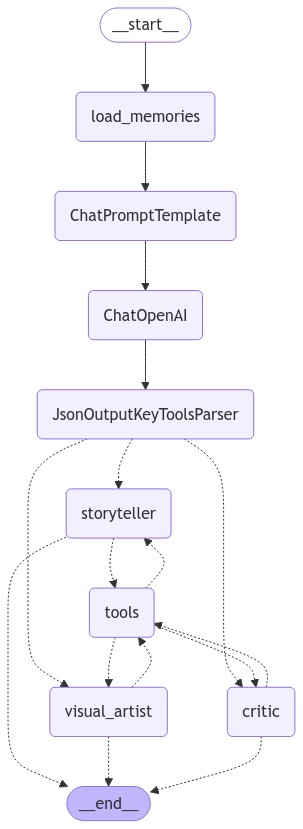

In [45]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [46]:
# Helper function to stream messages with multiagent graph
def stream_messages(text: str, thread: dict, image_url: str= None):
    # Initialize the content with the text message
    content = [{"type": "text", "text": text}]

    # If image_url is provided, append the image content
    if image_url:
        content.append({
            "type": "image_url",
            "image_url": {"url": image_url}
        })

    # Define the input for the graph stream
    input_data = {
        "messages": [
            HumanMessage(content=content)
        ]
    }

    # Stream the graph and print the output
    for s in graph.stream(input_data,config=thread):
        if "__end__" not in s:
            print(s)
            print("----")

In [48]:
# Look at vectore store collection structure
recall_vector_store.query(query_texts=["color"],where={"user_id": "2"})

{'ids': [[]],
 'distances': [[]],
 'metadatas': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

Memory Demo 
- Saved color preference across sessions
- Filter for PII: did not save address and name

In [49]:
# create thread and user_id
thread = {"configurable": {"user_id": "2", "thread_id": "1"}}

In [50]:
stream_messages(
    text="What do you think of my drawing?", 
    thread=thread,
    image_url="https://huggingface.co/datasets/jacob314159/child_drawings/resolve/main/205490118.jpeg",
)

{'load_memories': {'recall_memories': []}}
----
{'supervisor': {'next': 'critic'}}
----
{'critic': {'messages': [AIMessage(content="Wow, your drawing is so creative! I love how you used different colors and added those fun strips—it's like you made a beautiful collage! Keep exploring and trying new things in your art; you're doing an amazing job!", response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 25801, 'total_tokens': 25847, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8552ec53e1', 'finish_reason': 'stop', 'logprobs': None}, id='run-b1a18a4b-17ce-47a4-8b09-e1a4c02d1a30-0', usage_metadata={'input_tokens': 25801, 'output_tokens': 46, 'total_tokens': 25847})]}}
----


In [51]:
stream_messages(text="Any colors I can add to my drawing?",thread=thread)

{'load_memories': {'recall_memories': []}}
----
{'supervisor': {'next': 'critic'}}
----
{'critic': {'messages': [AIMessage(content='You could try adding some bright yellows or oranges for a pop of sunshine! Maybe some blues or purples could create a cool contrast with your existing colors. Experimenting with metallics, like gold or silver, could also add a fun sparkle! Enjoy mixing and matching!', response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 25863, 'total_tokens': 25919, 'prompt_tokens_details': {'cached_tokens': 1152}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8552ec53e1', 'finish_reason': 'stop', 'logprobs': None}, id='run-4857a63d-2420-439b-99a1-76c48a1e394b-0', usage_metadata={'input_tokens': 25863, 'output_tokens': 56, 'total_tokens': 25919})]}}
----


In [52]:
stream_messages(text="I prefer warm colors, like orange and yellow, over cold colors such as blue and purple.",thread=thread)

{'load_memories': {'recall_memories': []}}
----
{'supervisor': {'next': 'visual_artist'}}
----
{'visual_artist': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fUG6L892OEEx26gXH9NPwn4x', 'function': {'arguments': '{"memory":"User prefers warm colors, like orange and yellow, over cold colors such as blue and purple."}', 'name': 'save_recall_memory'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 25941, 'total_tokens': 25975, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8552ec53e1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e38eaf6e-bb45-4b66-bb35-c47dbf2add2f-0', tool_calls=[{'name': 'save_recall_memory', 'args': {'memory': 'User prefers warm colors, like orange and yellow, over cold colors such as blue and purple.'}, 'id': 'call_fUG6L892OEEx26gXH9NPwn4x', 'type

In [53]:
stream_messages(text="Btw this is my garden at 6919 Bell Drives, East Jessicastad, MO 76908",thread=thread)

Number of requested results 3 is greater than number of elements in index 2, updating n_results = 2


{'load_memories': {'recall_memories': ['User prefers warm colors, like orange and yellow, over cold colors such as blue and purple.']}}
----
{'supervisor': {'next': 'visual_artist'}}
----
{'visual_artist': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oqrUE7idp5zA60FRiFn61X3s', 'function': {'arguments': '{"memory":"User\'s garden is located at 6919 Bell Drive, East Jessicastad, MO 76908."}', 'name': 'save_recall_memory'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 26074, 'total_tokens': 26111, 'prompt_tokens_details': {'cached_tokens': 1280}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8552ec53e1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-49ced954-822f-4ca8-b7d0-36e747626143-0', tool_calls=[{'name': 'save_recall_memory', 'args': {'memory': "User's garden is located at 6919 Bell Drive, East Jessicastad

In [54]:
stream_messages(text="My name is Clara btw",thread=thread)

Number of requested results 3 is greater than number of elements in index 2, updating n_results = 2


{'load_memories': {'recall_memories': ['User prefers warm colors, like orange and yellow, over cold colors such as blue and purple.']}}
----
{'supervisor': {'next': 'visual_artist'}}
----
{'visual_artist': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zQOZPU7ELNA0zM44NUUCFK21', 'function': {'arguments': '{"memory":"User\'s name is Clara."}', 'name': 'save_recall_memory'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 26193, 'total_tokens': 26214, 'prompt_tokens_details': {'cached_tokens': 1408}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8552ec53e1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3b8a40d9-114e-4f89-b2b1-f3512f661286-0', tool_calls=[{'name': 'save_recall_memory', 'args': {'memory': "User's name is Clara."}, 'id': 'call_zQOZPU7ELNA0zM44NUUCFK21', 'type': 'tool_call'}], usage_metadata={'input_to

In [55]:
# Start a new session to test memory
thread = {"configurable": {"user_id": "2", "thread_id": "2"}}

In [56]:
stream_messages(text="What are top 3 colors can I use to draw an autumn garden?",thread=thread)

Number of requested results 3 is greater than number of elements in index 2, updating n_results = 2


{'load_memories': {'recall_memories': ['User prefers warm colors, like orange and yellow, over cold colors such as blue and purple.']}}
----
{'supervisor': {'next': 'visual_artist'}}
----
{'visual_artist': {'messages': [AIMessage(content='For an autumn garden, the top three colors you can use are:\n\n1. **Warm Orange:** This color represents the vibrant hues of fall leaves and pumpkins.\n2. **Deep Red:** A rich red captures the essence of autumn foliage and flowers like chrysanthemums.\n3. **Golden Yellow:** This color reflects the warmth of the sun and the beautiful golden leaves that fall during this season.\n\nUsing these colors together will create a warm and inviting autumn garden atmosphere!', response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 303, 'total_tokens': 395, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish

In [57]:
stream_messages(text="Where do I live?",thread=thread)

Number of requested results 3 is greater than number of elements in index 2, updating n_results = 2


{'load_memories': {'recall_memories': ['User prefers warm colors, like orange and yellow, over cold colors such as blue and purple.']}}
----
{'supervisor': {'next': 'critic'}}
----
{'critic': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EgbkvdqdKaxDXPOxoqb0Hdef', 'function': {'arguments': '{"query":"user location"}', 'name': 'search_recall_memories'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 411, 'total_tokens': 429, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-859f8f4b-16ed-4771-81f2-743e9116b3b1-0', tool_calls=[{'name': 'search_recall_memories', 'args': {'query': 'user location'}, 'id': 'call_EgbkvdqdKaxDXPOxoqb0Hdef', 'type': 'tool_call'}], usage_metadata={'input_tokens': 411, 'output_tokens': 18,

Number of requested results 3 is greater than number of elements in index 2, updating n_results = 2


{'tools': {'messages': [ToolMessage(content='["User prefers warm colors, like orange and yellow, over cold colors such as blue and purple."]', name='search_recall_memories', tool_call_id='call_EgbkvdqdKaxDXPOxoqb0Hdef')]}}
----
{'critic': {'messages': [AIMessage(content="I don't know where you live, but I remember you like warm colors! If you want to share your location, I can help you think of art ideas inspired by your surroundings!", response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 461, 'total_tokens': 498, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None}, id='run-a96c3fdf-0cb2-46ca-ad09-2f60f0d6c05e-0', usage_metadata={'input_tokens': 461, 'output_tokens': 37, 'total_tokens': 498})]}}
----
